In [1]:
# SED objects Tutorial
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from unyt import Angstrom, Hz, um, eV
from synthesizer.grid import Grid, get_available_lines
from synthesizer.sed import Sed
from synthesizer.filters import FilterCollection
from synthesizer.igm import Madau96

Let’s begin by initialising a grid:

- need a grid with incident spectra
NOTE FROM CHRIS: incident = stellar for grids that have no been processed with photoionisation code

In [2]:
# Define the grid
grid_name = "bc03_chabrier03-0.1,100.hdf5"
grid_dir = "../../synthesizer/data/grids/"
grid = Grid(grid_name, grid_dir=grid_dir, read_lines=False)
print(grid)

------------------------------
SUMMARY OF GRID
log10age: [ 5.          5.10000158  5.15000075  5.19999913  5.25000014  5.30000167
  5.35000172  5.40000062  5.45000109  5.50000169  5.55000197  5.600002
  5.65000234  5.7000024   5.75000207  5.80000252  5.85000259  5.90000315
  5.95000295  6.          6.0200006   6.04000071  6.05999863  6.0799984
  6.10000158  6.12000107  6.13999866  6.16000007  6.17999964  6.19999913
  6.22000081  6.23999979  6.2599998   6.27999984  6.2999995   6.31999873
  6.33999968  6.36000044  6.37999947  6.39999889  6.42000033  6.4400002
  6.45999977  6.47999975  6.49999895  6.51999984  6.53999893  6.55999993
  6.57999955  6.59999981  6.6199996   6.63999917  6.65999982  6.67999901
  6.69999893  6.71999962  6.73999931  6.75999929  6.77999958  6.79999907
  6.81999905  6.83999939  6.85999942  6.8799991   6.89999932  6.91999908
  6.93999921  6.95999912  6.97999882  6.99999913  7.0200006   7.04000071
  7.05999863  7.0799984   7.09999813  7.11999778  7.13999866  7.1600000

Next, let’s define a target log10age and metallicity and use the built-in Grid method to get the grid point and then extract the spectrum for that grid point.



In [4]:
log10age = 6.0  # log10(age/yr)
metallicity = 0.01
spectra_id = "stellar"
grid_point = grid.get_grid_point((log10age, metallicity))
sed = grid.get_spectra(grid_point, spectra_id=spectra_id)
sed.lnu *= 1e8  # make the SED bigger

Like other synthesizer objects, we get some basic information about the Sed object by using the print command:



In [5]:
print(sed)


----------
SUMMARY OF SED 
Number of wavelength points: 6900 
Wavelength range: [91.00 Å,             1600000.00 Å] 
log10(Peak luminosity/erg/(Hz*s)):             29.08 
log10(Bolometric luminosity/erg/s):36.571308890664774----------


Sed objects contain a wavelength grid and luminosity in the lam and lnu attributes. Both come with units making them easy to convert:
WAVELENGTH = lam
LUMINOSITY = lnu


In [7]:
print('wavelength:', sed.lam)
print('luminosity:',sed.lnu)

wavelength: [9.1e+01 9.4e+01 9.6e+01 ... 1.2e+06 1.4e+06 1.6e+06] Å
luminosity: [6.69354123e+16 1.76478872e+17 3.29299242e+17 ... 4.79460439e+23
 3.50264056e+23 2.66802978e+23] erg/(Hz*s)


These also have more descriptive aliases:



In [8]:
print(sed.wavelength)
print(sed.luminosity_nu)

[9.1e+01 9.4e+01 9.6e+01 ... 1.2e+06 1.4e+06 1.6e+06] Å
[6.69354123e+16 1.76478872e+17 3.29299242e+17 ... 4.79460439e+23
 3.50264056e+23 2.66802978e+23] erg/(Hz*s)


Thus we can easily make a plot:



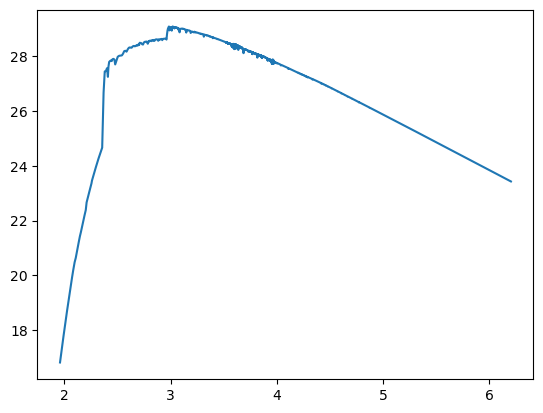

In [9]:
plt.plot(np.log10(sed.lam), np.log10(sed.lnu))
plt.show()

We can also get the luminosity (L) or spectral luminosity density per /AA (L_{$\lambda$})
):

In [10]:
print(sed.luminosity)
print(sed.llam)

[2.20513536e+33 5.62840795e+33 1.02834822e+34 ... 1.19782186e+36
 7.50046587e+35 4.99909503e+35] erg/s
[2.42322567e+31 5.98766803e+31 1.07119606e+32 ... 9.98184886e+29
 5.35747562e+29 3.12443440e+29] erg/(s*Å)


# Scaling Seds
Sed objects can be easily scaled via the * operator. For example,



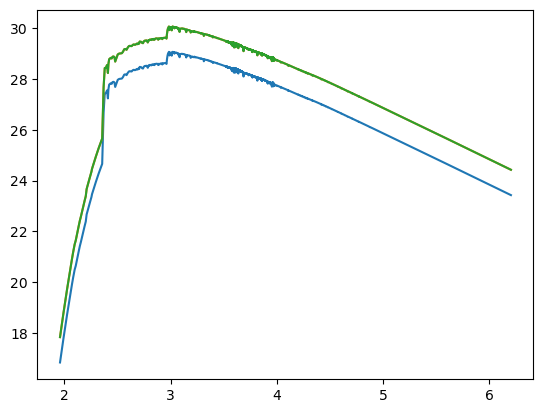

In [11]:
sed3 = sed * 10
sed4 = 10 * sed

plt.plot(np.log10(sed.lam), np.log10(sed.lnu))
plt.plot(np.log10(sed3.lam), np.log10(sed3.lnu))
plt.plot(np.log10(sed4.lam), np.log10(sed4.lnu))
plt.show()

# Methods
## get_bolometric_luminosity()
This method allows us to calculate the bolometric luminosity of the sed.


In astrophysics, luminosity and bolometric luminosity are related but represent different concepts:

Luminosity: Luminosity refers to the total amount of energy emitted by an astronomical object, such as a star or a galaxy, per unit of time. It is typically measured in watts. Luminosity gives a measure of the intrinsic brightness of the object, irrespective of its distance from an observer.

Bolometric Luminosity: Bolometric luminosity is a specific type of luminosity that accounts for all wavelengths of electromagnetic radiation emitted by an object. It includes not only visible light but also ultraviolet, infrared, and any other wavelengths. Essentially, it's the total luminosity emitted across the entire electromagnetic spectrum. Bolometric luminosity is particularly useful when comparing different types of astronomical objects or studying objects that emit significant amounts of energy outside the visible spectrum.

In summary, while luminosity refers to the total energy emitted by an astronomical object per unit time, bolometric luminosity specifically accounts for energy emitted across all wavelengths of the electromagnetic spectrum.


In [12]:
sed.measure_bolometric_luminosity()


unyt_quantity(3.72656663e+44, 'erg/s')

By default the above simply sums up the spectrum. However, we can also integrate the spectrum instead:


In [17]:
#sed.measure_bolometric_luminosity(method="quad")
# raises error, data too small.


Under-the-hood the above uses a function to get the luminosity at a particular frequency or wavelength:

In [20]:
sed.get_lnu_at_lam(1500 * Angstrom)


unyt_quantity(8.51540526e+28, 'erg/(Hz*s)')

In [21]:
sed.get_lnu_at_nu(1e14 * Hz)


unyt_quantity(7.92794883e+26, 'erg/(Hz*s)')

In [22]:
sed.measure_window_luminosity((1400.0 * Angstrom, 1600.0 * Angstrom))


unyt_quantity(2.19291423e+43, 'erg/s')

In [23]:
sed.measure_window_luminosity((0.14 * um, 0.16 * um))


unyt_quantity(2.19291423e+43, 'erg/s')

In [24]:
sed.measure_window_lnu((1400.0 * Angstrom, 1600.0 * Angstrom))


unyt_quantity(8.17942721e+28, 'erg/(Hz*s)')

In [25]:
sed.measure_window_lnu(
    (1400.0 * Angstrom, 1600.0 * Angstrom), method="average"
)

unyt_quantity(8.20206006e+28, 'erg/(Hz*s)')

In [26]:
sed.measure_window_lnu((1400, 1600) * Angstrom, method="quad")


unyt_quantity(8.19677818e+28, 'erg/(Hz*s)')

We can also measure a spectral break by providing two windows, e.g.



In [27]:
sed.measure_break((3400, 3600) * Angstrom, (4150, 4250) * Angstrom)


unyt_quantity(0.84942101, '(dimensionless)')

There are also a few in-built break methods, e.g. measure_Balmer_break()



In [28]:
sed.measure_balmer_break()


unyt_quantity(0.84942101, '(dimensionless)')

In [30]:
sed.measure_d4000()


unyt_quantity(0.95648762, '(dimensionless)')

We can also measure absorption line indices:



In [31]:
sed.measure_index(
    (1500, 1600) * Angstrom, (1400, 1500) * Angstrom, (1600, 1700) * Angstrom
)

unyt_quantity(3.12102627, 'Å')

We can also measure the UV spectral slope $\beta$

In [32]:
sed.measure_beta()


-3.1140418258374636

By default this uses a single window and fits the spectrum by a power-law. However, we can also specify two windows as below, in which case the luminosity in each window is calcualted and used to infer a slope:

In [33]:
sed.measure_beta(window=(1250, 1750, 2250, 2750))


-3.1059130330325773

We can also measure ionising photon production rates for a particular ionisation energy:



In [34]:
sed.calculate_ionising_photon_production_rate(
    ionisation_energy=13.6 * eV, limit=1000
)

/Users/am/anaconda3/envs/allyenv/lib/python3.9/site-packages/synthesizer/sed.py:1280: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(


4.6994090046953e+54

# Observed frame SED
To do this we need to provide a cosmology, using an astropy.cosmology object, a redshift $z$, and optionally an IGM absorption model.

In [35]:
from astropy.cosmology import Planck18 as cosmo

z = 10.0  # redshift
sed.get_fnu(cosmo, z, igm=Madau96)  # generate observed frame spectra

unyt_array([0.        , 0.        , 0.        , ..., 0.00039231, 0.0002866 ,
       0.00021831], 'nJy')

In [36]:
z = 0.5  # redshift
sed.get_fnu(cosmo, z, igm=Madau96)  # generate observed frame spectra

unyt_array([8.73082564e-09, 2.28824996e-08, 4.25286042e-08, ...,
       7.05145843e-02, 5.15135813e-02, 3.92389018e-02], 'nJy')

# Photometry
Once we have computed the observed frame SED there is a method on an Sed object that allows us to calculate observed photometry (the same is of course true for rest frame photometry). However, first we need to instantiate a FilterCollection object.



In [37]:
filter_codes = [
    f"JWST/NIRCam.{f}"
    for f in [
        "F070W",
        "F090W",
        "F115W",
        "F150W",
        "F200W",
        "F277W",
        "F356W",
        "F444W",
    ]
]  # define a list of filter codes
fc = FilterCollection(filter_codes, new_lam=grid.lam)

In [38]:
# Measure observed photometry
fluxes = sed.get_photo_fluxes(fc)
print(fluxes)


------------------------------------------------------------------
|                       PHOTOMETRY (FLUX)                        |
|------------------------------------|---------------------------|
| JWST/NIRCam.F070W (λ = 7.04e+03 Å) | 2.95e+03 erg/(Hz*cm**2*s) |
|------------------------------------|---------------------------|
| JWST/NIRCam.F090W (λ = 9.02e+03 Å) | 1.96e+03 erg/(Hz*cm**2*s) |
|------------------------------------|---------------------------|
| JWST/NIRCam.F115W (λ = 1.15e+04 Å) | 1.33e+03 erg/(Hz*cm**2*s) |
|------------------------------------|---------------------------|
| JWST/NIRCam.F150W (λ = 1.50e+04 Å) | 8.32e+02 erg/(Hz*cm**2*s) |
|------------------------------------|---------------------------|
| JWST/NIRCam.F200W (λ = 1.99e+04 Å) | 5.08e+02 erg/(Hz*cm**2*s) |
|------------------------------------|---------------------------|
| JWST/NIRCam.F277W (λ = 2.76e+04 Å) | 2.84e+02 erg/(Hz*cm**2*s) |
|------------------------------------|------------------------

# Multiple SEDs
The Sed object can actually hold an array of seds and the methods should all work fine.

Let’s create an Sed object with two seds:

In [39]:
sed2 = Sed(sed.lam, np.array([sed.lnu, sed.lnu * 2]))


In [40]:
sed2.measure_window_lnu((1400, 1600) * Angstrom)


unyt_array([8.17942721e+28, 1.63588544e+29], 'erg/(Hz*s)')

In [41]:
sed2.measure_window_lnu((1400, 1600) * Angstrom, method="average")


unyt_array([8.20206006e+28, 1.64041201e+29], 'erg/(Hz*s)')

In [42]:
sed2.measure_beta()


array([-3.11404183, -3.11404183])

In [43]:
sed2.measure_beta(window=(1250, 1750, 2250, 2750))


array([-3.10591303, -3.10591303])

In [44]:
sed2.measure_balmer_break()


unyt_array([0.84942101, 0.84942101], '(dimensionless)')

In [45]:
sed2.measure_index(
    (1500, 1600) * Angstrom, (1400, 1500) * Angstrom, (1600, 1700) * Angstrom
)

unyt_array([3.12102627, 3.12102627], 'Å')

# Combining SEDs
Seds can be combined either via concatenation to produce a single Sed holding multiple spectra from the combined Seds, or by addition to add the spectra contained in two Seds.

To concatenate spectra we can use Sed.concat().



In [47]:
print("Shapes before:", sed._lnu.shape, sed2._lnu.shape)
sed3 = sed2.concat(sed)
print("Combined shape:", sed3._lnu.shape)

Shapes before: (6900,) (2, 6900)
Combined shape: (3, 6900)


Sed.concat can take an arbitrary number of Sed objects to combine.



In [48]:
sed4 = sed2.concat(sed, sed2, sed3)
print("Combined shape:", sed4._lnu.shape)

Combined shape: (8, 6900)


If we want to add the spectra of 2 Sed objects we simply apply the + operator. However, unlike concat, this will only work for Seds with identical shapes.



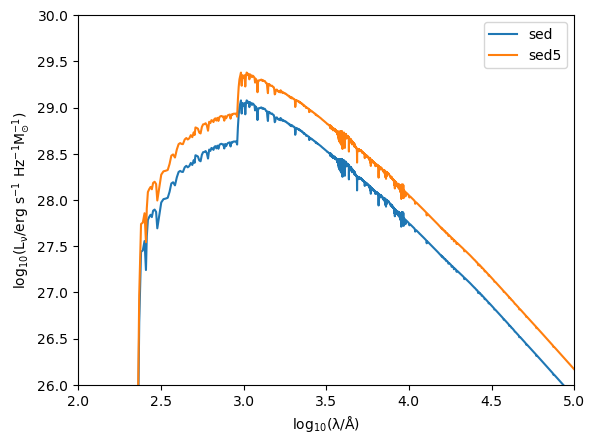

In [49]:
sed5 = sed + sed
plt.plot(np.log10(sed.lam), np.log10(sed.lnu), label="sed")
plt.plot(np.log10(sed5.lam), np.log10(sed5.lnu), label="sed5")
plt.ylim(26, 30)
plt.xlim(2, 5)
plt.xlabel(r"$\rm log_{10}(\lambda/\AA)$")
plt.ylabel(r"$\rm log_{10}(L_{\nu}/erg\ s^{-1}\ Hz^{-1} M_{\odot}^{-1})$")
plt.legend()
plt.show()
plt.close()

The Sed includes a method to resample an sed, e.g. to lower-resolution or to match observations.



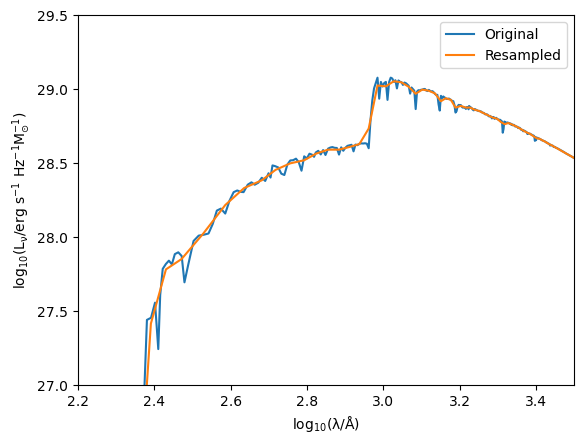

In [50]:
sed6 = sed.get_resampled_sed(5)
plt.plot(np.log10(sed.lam), np.log10(sed.lnu), label="Original")
plt.plot(np.log10(sed6.lam), np.log10(sed6.lnu), label="Resampled")
plt.xlim(2.2, 3.5)
plt.ylim(27.0, 29.5)
plt.xlabel(r"$\rm log_{10}(\lambda/\AA)$")
plt.ylabel(r"$\rm log_{10}(L_{\nu}/erg\ s^{-1}\ Hz^{-1} M_{\odot}^{-1})$")
plt.legend()
plt.show()
plt.close()

In [51]:
print(
    sed.measure_bolometric_luminosity() / sed3.measure_bolometric_luminosity()
)

[1.  0.5 1. ] dimensionless


To apply attenuation to an Sed you can use the apply_attenuation method and pass the optical depth. An instance of a dust curve can also be provided but this defaults to a power law with slope = 1 (synthesizer.dust.attenuation.PowerLaw(slope=1)).



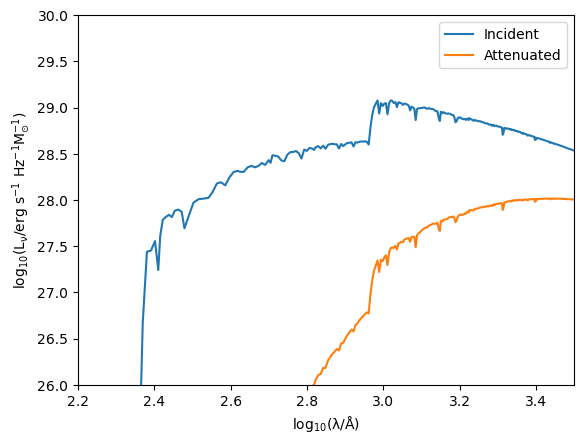

In [52]:
sed4_att = sed4.apply_attenuation(tau_v=0.7)

plt.plot(np.log10(sed4.lam), np.log10(sed4.lnu[0, :]), label="Incident")
plt.plot(
    np.log10(sed4_att.lam), np.log10(sed4_att.lnu[0, :]), label="Attenuated"
)
plt.xlim(2.2, 3.5)
plt.ylim(26.0, 30.0)
plt.xlabel(r"$\rm log_{10}(\lambda/\AA)$")
plt.ylabel(r"$\rm log_{10}(L_{\nu}/erg\ s^{-1}\ Hz^{-1} M_{\odot}^{-1})$")
plt.legend()
plt.show()
plt.close()

The only other argument apply_attenuation can take is a mask for applying attenuation to speicifc spectra in an Sed with multiple spectra (like an Sed containing the spectra for multiple particles for instance.)

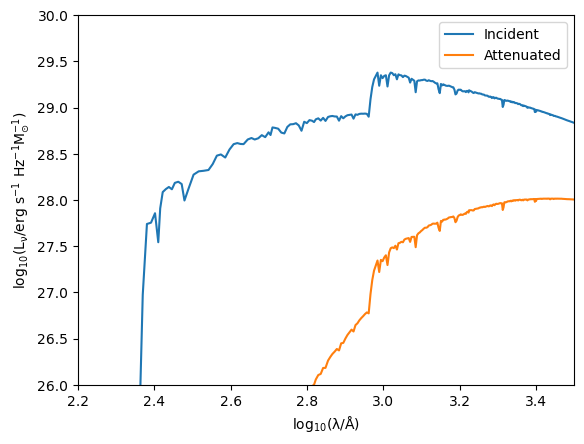

In [53]:
sed7_att = sed4.apply_attenuation(
    tau_v=0.7, mask=np.array([1, 0, 0, 0, 0, 0, 0, 0], dtype=bool)
)

plt.plot(np.log10(sed7_att.lam), np.log10(sed4.lnu[1, :]), label="Incident")
plt.plot(
    np.log10(sed7_att.lam), np.log10(sed7_att.lnu[0, :]), label="Attenuated"
)
plt.xlim(2.2, 3.5)
plt.ylim(26.0, 30.0)
plt.xlabel(r"$\rm log_{10}(\lambda/\AA)$")
plt.ylabel(r"$\rm log_{10}(L_{\nu}/erg\ s^{-1}\ Hz^{-1} M_{\odot}^{-1})$")
plt.legend()
plt.show()
plt.close()

If you have an attenuated SED, a natural quantity to calculate is the extinction of that spectra ($A$). This can be done either at the wavelengths of the Sed, an arbitrary wavelength/wavelength array, or at commonly used values (1500 and 5500 angstrom) using functions available in the sed module. Note that these functions return the extinction/attenuation in magnitudes. Below is a demonstration.

In [55]:
from unyt import um, angstrom
from synthesizer.sed import (
    get_attenuation,
    get_attenuation_at_lam,
    get_attenuation_at_1500,
    get_attenuation_at_5500,
)

# Get an intrinsic spectra
grid_point = grid.get_grid_point((7, 0.01))
int_sed = grid.get_spectra(grid_point, spectra_id="stellar")

# Get the attenuated spectra
att_sed = int_sed.apply_attenuation(tau_v=0.7)

# Get attenuation at sed.lam
attenuation = get_attenuation(int_sed, att_sed)
print(attenuation[~np.isnan(attenuation)])

# Get attenuation at 5 microns
att_at_5 = get_attenuation_at_lam(5 * um, int_sed, att_sed)
print(att_at_5)

# Get attenuation at an arbitrary range of wavelengths
att_at_range = get_attenuation_at_lam(
    np.linspace(5000, 10000, 5) * angstrom, int_sed, att_sed
)
print(att_at_range)

# Get attenuation at 1500 angstrom
att_at_1500 = get_attenuation_at_1500(int_sed, att_sed)
print(att_at_1500)

# Get attenuation at 5500 angstrom
att_at_5500 = get_attenuation_at_5500(int_sed, att_sed)
print(att_at_5500)

[4.59349933e+01 4.44689829e+01 4.35425457e+01 ... 3.48340366e-03
 2.98577456e-03 2.61255274e-03]
0.08360202217446464
[0.83601688 0.6688135  0.55734459 0.47772393 0.41800948]
2.7867538894779713
0.7600153433306907
